[![logo](https://climate.copernicus.eu/sites/default/files/custom-uploads/branding/LogoLine_horizon_C3S.png)](https://climate.copernicus.eu)

# The ugly duckling: accessing and visualizing TA data at NUT0 aggregation level from the Ensemble of CMIP6 Climate projections

This Notebook provides a practical introduction on how to access and process the CMIP6 projections data available in the Pan-European Climate Database version 4.2 ([PECD4.2](https://cds.climate.copernicus.eu/datasets/sis-energy-pecd?tab=overview)) dataset of the Climate Data Store (CDS) implemented by the Copernicus Climate Change Service (C3S).

The workflow shows:
* how to download from CDS NUT0 TA data for the CMIP6 6 models x 4 scenarios that are available in the PECD4.2
* how to create a subsample of the NUT0 TA downloaded data for a particular country 
* how to concatenate the information from the historical reanalysis
* how to calculate monthly/annual averages for selected years
* how to plot different types of time series
* how to derive estimates about climate change trends

>**Note**:
>
> For the sake of simplicity, this tutorial will make use only of spatially aggregated data (NUT0 aggregation), for only one country and one climate indicator (TA), averaged annually and for selected years. Interested users can expand the range of years considered or use different climate/energy indicators or use gridded data considering a single grid point (with slightly modifications).

## Learning objectives 🧠

1. Learn how to create a customised pandas dataframe
2. Learn how to select different columns/rows to see climate change impacts
3. Learn how to plot the timeserie of an ensemble of climate projections
4. Learn how to compare climate projections to the present/recent past

## Target audience 🎯

Anyone interested in learning how to predicting climate variables through the use of model ensembles.

## Prepare your environment

### Import required packages

This script begins by importing several Python libraries that are essential for data handling, file management, and visualization:

1. [glob](https://docs.python.org/3/library/glob.html): A module used for searching files in a directory using wildcard patterns. For example, it can be used to find all .csv files in a folder with a single line of code. This is useful for batch processing datasets.
2. [os](https://docs.python.org/3/library/os.html): Provides functions to interact with the operating system, especially for file and directory operations. It allows the script to build portable file paths, list contents of folders, or check if files exist.
3. [pandas](https://pandas.pydata.org/) (imported as pd): A powerful library for data manipulation and analysis, especially structured data like tables (DataFrames). It is used extensively for reading/writing CSV files, cleaning data, and performing statistical analysis.
4. [defaultdict](https://docs.python.org/3/library/collections.html#collections.defaultdict) from [collections](https://docs.python.org/3/library/collections.html): A specialized dictionary that simplifies code by automatically initializing missing keys with a default value, such as an empty list or zero. This is especially handy when grouping or aggregating values dynamically without needing to check if a key exists first.
5. [re](https://docs.python.org/3/library/re.html): The regular expression module, which allows for advanced string searching and manipulation. It's commonly used for tasks like extracting patterns from filenames, renaming columns, or parsing variable names with suffixes like _x, _y, etc.
6. [matplotlib.pyplot](https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html) (imported as plt): A widely used plotting library for creating static visualizations in Python. It enables the script to generate line plots, scatter plots, bar charts, and more — ideal for visualizing time series or statistical trends.
7. [numpy](https://numpy.org/doc/stable/) (imported as np): A foundational library for numerical computing in Python. It offers efficient operations on arrays, mathematical functions (like mean, sqrt, etc.), and is often used in tandem with Pandas for numerical calculations like RMSE or averages.
8. [reduce](https://docs.python.org/3/library/functools.html#functools.reduce) from [functools](https://docs.python.org/3/library/functools.html): A higher-order function that applies a binary function cumulatively to the elements of an iterable, from left to right. For example, it can be used to merge multiple dataframes or accumulate values across a list.
9. [cdsapi](https://github.com/ecmwf/cdsapi?tab=readme-ov-file): A Python library that provides programmatic access to the Copernicus Climate Data Store (CDS), allowing to download the relevant data for this work.

Together, these imports set up the core environment for reading multiple files, manipulating datasets, computing statistical summaries, and producing visual plots — all essential steps in a typical data science or climate analysis workflow.

In [2]:
import glob
import os
import pandas as pd
from collections import defaultdict
import re
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce
import cdsapi

## Input data: download, list, read and access

### Set up the CDS API and your credentials

This step is essential to be able to download the data. To learn how to use the CDS API, see the [official guide](https://cds.climate.copernicus.eu/how-to-api). If you have already set up your .cdsapirc file locally, you can upload it directly to your home directory.

Alternatively, you can replace None in the following code cell with your API Token as a string (i.e. enclosed in quotes, like ```"your_api_key"```). Your token can be found on the CDS portal at: https://cds.climate.copernicus.eu/profile (you will need to log in to view your credentials).
Remember to agree to the Terms and Conditions of every dataset you intend to download.

In [3]:
# If you have already setup your .cdsapirc file you can leave this as None
cdsapi_key = None
cdsapi_url = "https://cds.climate.copernicus.eu/api"

### Download the data

The data can be downloaded from the PECD CDS download form, by ticking the boxes of interest. Once all the required information is manually selected, scroll to the bottom of the form and click on "Show API request". This will reveal a code block that can be copied and pasted directly into a cell of your Jupyter Notebook. This step has already been done for you in the cell below, but if you'd like to try it yourself, visit the [CDS download form](https://cds.climate.copernicus.eu/datasets/sis-energy-pecd?tab=download).

In this example we retrieve the "2m temperature" (i.e. 2-metre air-temperature) variable at "NUTS 0" spatial resolution from the PECD version "PECD4.2". Two temporal streams are combined:
- Historical data derived from the "ERA5 reanalysis", covering" the single years 1995, 2000, 2005, 2010 and 2015.
- Future projections from six CMIP6 models ("AWI-CM-1-1-MR", "BCC-CSM2-MR", "CMCC-CM2-SR5", "EC-Earth3", "MPI-ESM1-2-HR" and "MRI-ESM2-0"). 
For each model we request the years 2015, 2050 and 2100 under the emission scenarios "SSP1-2.6", "SSP2-4.5", "SSP3-7.0" and "SSP5-8.5".

To keep each request within CDS limits, we split the job into seven smaller requests: one for the historical data and one for each CMIP6 model. 
The next code cells show the API request for the historical data and how to succesfully perform the download. Later, we will repeat the procedure for the remaining six model-specific requests.

In [4]:
# ERA5 historical
dataset = "sis-energy-pecd"
request = {
    "pecd_version": "pecd4_2",
    "temporal_period": ["historical"],
    "origin": ["era5_reanalysis"],
    "year": ["1995", "2000", "2005", "2010", "2015"],
    "variable": ["2m_temperature"],
    "spatial_resolution": ["nuts_0"],
}

Before running the download we can make sure there is a dedicated folder ready to host the data.

In [5]:
input_dir = "cds_data/climate_change_impacts/"
os.system(f"mkdir -p {input_dir}")

0

Now that it is all set, we are ready to download the data.

In [ ]:
# initialize Client object
client = cdsapi.Client(cdsapi_url, cdsapi_key)
# call the retrieve method that downloads data
client.retrieve(dataset, request, f"{input_dir}/era5_hist.zip")

We can now proceed to generate the six requests relative to future projection data and download them. This is done in the next six code cells.

In [ ]:
# AWI-CM-1-1-MR future projections
dataset = "sis-energy-pecd"
request = {
    "pecd_version": "pecd4_2",
    "temporal_period": ["future_projections"],
    "origin": ["awi_cm_1_1_mr"],
    "emission_scenario": ["ssp1_2_6", "ssp2_4_5", "ssp3_7_0", "ssp5_8_5"],
    "year": ["2015", "2050", "2100"],
    "variable": ["2m_temperature"],
    "spatial_resolution": ["nuts_0"],
}

client.retrieve(dataset, request, f"{input_dir}/awi_cm_1_1_mr_proj.zip")

In [ ]:
# BCC-CSM2-MR future projections
dataset = "sis-energy-pecd"
request = {
    "pecd_version": "pecd4_2",
    "temporal_period": ["future_projections"],
    "origin": ["bcc_csm2_mr"],
    "emission_scenario": ["ssp1_2_6", "ssp2_4_5", "ssp3_7_0", "ssp5_8_5"],
    "year": ["2015", "2050", "2100"],
    "variable": ["2m_temperature"],
    "spatial_resolution": ["nuts_0"],
}

client.retrieve(dataset, request, f"{input_dir}/bcc_csm2_mr_proj.zip")

In [ ]:
# CMCC-CM2-SR5 future projections
dataset = "sis-energy-pecd"
request = {
    "pecd_version": "pecd4_2",
    "temporal_period": ["future_projections"],
    "origin": ["cmcc_cm2_sr5"],
    "emission_scenario": ["ssp1_2_6", "ssp2_4_5", "ssp3_7_0", "ssp5_8_5"],
    "year": ["2015", "2050", "2100"],
    "variable": ["2m_temperature"],
    "spatial_resolution": ["nuts_0"],
}

client.retrieve(dataset, request, f"{input_dir}/cmcc_cm2_sr5_proj.zip")

In [ ]:
# EC-Earth3 future projections
dataset = "sis-energy-pecd"
request = {
    "pecd_version": "pecd4_2",
    "temporal_period": ["future_projections"],
    "origin": ["ec_earth3"],
    "emission_scenario": ["ssp1_2_6", "ssp2_4_5", "ssp3_7_0", "ssp5_8_5"],
    "year": ["2015", "2050", "2100"],
    "variable": ["2m_temperature"],
    "spatial_resolution": ["nuts_0"],
}

client.retrieve(dataset, request, f"{input_dir}/ec_earth3_proj.zip")

In [ ]:
# MPI-ESM1-2-HR future projections
dataset = "sis-energy-pecd"
request = {
    "pecd_version": "pecd4_2",
    "temporal_period": ["future_projections"],
    "origin": ["mpi_esm1_2_hr"],
    "emission_scenario": ["ssp1_2_6", "ssp2_4_5", "ssp3_7_0", "ssp5_8_5"],
    "year": ["2015", "2050", "2100"],
    "variable": ["2m_temperature"],
    "spatial_resolution": ["nuts_0"],
}

client.retrieve(dataset, request, f"{input_dir}/mpi_esm1_2_hr_proj.zip")

In [ ]:
# MRI-ESM2-0 future projections
dataset = "sis-energy-pecd"
request = {
    "pecd_version": "pecd4_2",
    "temporal_period": ["future_projections"],
    "origin": ["mri_esm2_0"],
    "emission_scenario": ["ssp1_2_6", "ssp2_4_5", "ssp3_7_0", "ssp5_8_5"],
    "year": ["2015", "2050", "2100"],
    "variable": ["2m_temperature"],
    "spatial_resolution": ["nuts_0"],
}

client.retrieve(dataset, request, f"{input_dir}/mri_esm2_0_proj.zip")

Since our data are inside zipped files we need to unzip them. The final CSV files will have a name according to the naming conventions of Pan-European Climate Database. You can find the explanation of the different fields in the [production guide](https://confluence.ecmwf.int/pages/viewpage.action?pageId=439598955#ClimateandenergyrelatedvariablesfromthePanEuropeanClimateDatabasederivedfromreanalysisandclimateprojections:Productuserguide(PUG)-Filenamesconventionandcharacteristics) of the PECD.

In [ ]:
# Unzipping every file in our folder
for fname in os.listdir(input_dir):
    if fname.endswith(".zip"):
        subfolder = fname.split(".")[0]
        os.system(f"unzip {input_dir}/{fname} -d {input_dir}")

### Getting the list of input data

We use glob and os to get a list of files in our download folder whose names satisfy certain "rules" or "regular expression" (regex). In our case, the rule is that the name should contain something (anything-*) then TA then again something then it ends with "PECD4.2_fv1.csv". Do you notice some "common/repetitive features" in the names of the files? Yes? List them!

In [6]:
# Get all CSV files
csv_files = sorted(glob.glob(os.path.join(input_dir, "*TA*PECD4.2_fv1.csv")))

# Show the list
csv_files

['cds_data/climate_change_impacts/H_ERA5_ECMW_T639_TA-_0002m_Pecd_NUT0_S199501010000_E199512312300_INS_TIM_01h_COM_noc_org_NA_NA---_NA---_NA---_PECD4.2_fv1.csv',
 'cds_data/climate_change_impacts/H_ERA5_ECMW_T639_TA-_0002m_Pecd_NUT0_S200001010000_E200012312300_INS_TIM_01h_COM_noc_org_NA_NA---_NA---_NA---_PECD4.2_fv1.csv',
 'cds_data/climate_change_impacts/H_ERA5_ECMW_T639_TA-_0002m_Pecd_NUT0_S200501010000_E200512312300_INS_TIM_01h_COM_noc_org_NA_NA---_NA---_NA---_PECD4.2_fv1.csv',
 'cds_data/climate_change_impacts/H_ERA5_ECMW_T639_TA-_0002m_Pecd_NUT0_S201001010000_E201012312300_INS_TIM_01h_COM_noc_org_NA_NA---_NA---_NA---_PECD4.2_fv1.csv',
 'cds_data/climate_change_impacts/H_ERA5_ECMW_T639_TA-_0002m_Pecd_NUT0_S201501010000_E201512312300_INS_TIM_01h_COM_noc_org_NA_NA---_NA---_NA---_PECD4.2_fv1.csv',
 'cds_data/climate_change_impacts/P_CMI6_AWI-_AWCM_TA-_0002m_Pecd_NUT0_S201501010000_E201512312300_INS_TIM_01h_NA-_cdf_org_NA_SP126_NA---_NA---_PECD4.2_fv1.csv',
 'cds_data/climate_change_im

What happens if we add a "P" at the beginning of our regex expression?

In [7]:
# Get all CSV files
csv_files = sorted(glob.glob(os.path.join(input_dir, "P*TA*PECD4.2_fv1.csv")))

# Show the list
csv_files

['cds_data/climate_change_impacts/P_CMI6_AWI-_AWCM_TA-_0002m_Pecd_NUT0_S201501010000_E201512312300_INS_TIM_01h_NA-_cdf_org_NA_SP126_NA---_NA---_PECD4.2_fv1.csv',
 'cds_data/climate_change_impacts/P_CMI6_AWI-_AWCM_TA-_0002m_Pecd_NUT0_S201501010000_E201512312300_INS_TIM_01h_NA-_cdf_org_NA_SP245_NA---_NA---_PECD4.2_fv1.csv',
 'cds_data/climate_change_impacts/P_CMI6_AWI-_AWCM_TA-_0002m_Pecd_NUT0_S201501010000_E201512312300_INS_TIM_01h_NA-_cdf_org_NA_SP370_NA---_NA---_PECD4.2_fv1.csv',
 'cds_data/climate_change_impacts/P_CMI6_AWI-_AWCM_TA-_0002m_Pecd_NUT0_S201501010000_E201512312300_INS_TIM_01h_NA-_cdf_org_NA_SP585_NA---_NA---_PECD4.2_fv1.csv',
 'cds_data/climate_change_impacts/P_CMI6_AWI-_AWCM_TA-_0002m_Pecd_NUT0_S205001010000_E205012312300_INS_TIM_01h_NA-_cdf_org_NA_SP126_NA---_NA---_PECD4.2_fv1.csv',
 'cds_data/climate_change_impacts/P_CMI6_AWI-_AWCM_TA-_0002m_Pecd_NUT0_S205001010000_E205012312300_INS_TIM_01h_NA-_cdf_org_NA_SP245_NA---_NA---_PECD4.2_fv1.csv',
 'cds_data/climate_change_im

### Reading the input data

Let's use read_csv to read an example file. Does it work?

In [8]:
f_name = (
    "P_CMI6_MRI-_MRM2_TA-_0002m_Pecd_NUT0_"
    "S210001010000_E210012312100_INS_TIM_01h_NA-_cdf_org_"
    "NA_SP585_NA---_NA---_PECD4.2_fv1.csv"
)
test_file = input_dir + f_name
data = pd.read_csv(test_file)

ParserError: Error tokenizing data. C error: Expected 1 fields in line 53, saw 53


I'm sure you have seen this before!

In [10]:
data = pd.read_csv(test_file, comment="#")
data

,Date,AL,AT,BA,BE,BG,CH,CY,CZ,DE,...,RS,SE,SI,SK,SY,TN,TR,UA,UK,XK
0,2100-01-01 00:00:00,1.36609,-1.91302,1.48572,10.19357,-2.14633,-1.40479,10.69113,0.22552,6.73184,...,-0.45090,1.32892,1.92664,-1.96707,7.09155,11.24347,0.12973,-1.50812,5.41101,-1.37469
1,2100-01-01 01:00:00,1.26645,-1.86905,1.80579,10.63092,-2.20532,-1.38727,10.54520,0.26416,6.69589,...,-0.48074,1.45041,2.25702,-2.13617,6.94855,11.18350,0.07126,-1.59171,4.96259,-1.46020
2,2100-01-01 02:00:00,0.91705,-1.82224,1.91464,11.06021,-2.52289,-1.40393,10.25165,0.36038,6.67242,...,-0.74481,1.53616,2.43665,-2.38391,6.37884,10.60260,-0.30783,-1.86826,4.54623,-1.82629
3,2100-01-01 03:00:00,0.73416,-1.73941,2.22971,11.35553,-2.69183,-1.23001,10.03522,0.55426,6.73080,...,-0.83975,1.65637,2.61597,-2.50784,6.24084,10.16342,-0.53064,-2.04044,4.21051,-1.95099
4,2100-01-01 04:00:00,0.64996,-1.56723,2.58588,11.52115,-2.82492,-0.91260,10.04767,0.84760,6.88562,...,-0.82373,1.74582,2.89908,-2.56226,6.17487,10.08344,-0.57141,-2.22354,3.92102,-2.05710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8753,2100-12-31 17:00:00,7.45224,-3.75116,0.00226,1.99976,2.27551,-3.28870,16.17618,-1.44861,0.91373,...,0.34778,-8.19196,-0.58032,-1.16843,12.43796,17.59198,5.58820,0.21863,2.69507,1.78030
8754,2100-12-31 18:00:00,6.61249,-4.26175,-1.00272,1.89770,1.65320,-3.99570,15.85599,-1.66183,0.72165,...,-0.25528,-8.39673,-1.47391,-1.56952,12.24484,16.68219,5.38623,0.02698,2.32477,1.19006
8755,2100-12-31 19:00:00,5.95752,-4.60339,-1.76248,1.81516,1.24152,-4.54639,15.79321,-1.78903,0.54565,...,-0.70181,-8.55624,-2.04861,-1.78336,12.38174,16.03098,5.38855,-0.02649,2.05515,0.68723
8756,2100-12-31 20:00:00,4.83496,-4.97058,-2.62332,1.66800,0.37848,-5.03076,15.51416,-1.98138,0.37650,...,-1.46698,-8.73941,-2.63141,-2.12540,11.74670,15.00839,4.83582,-0.29712,1.92761,-0.30341


 Each of our input files contains 760 (more or less) timesteps and 53 columns; the first column is called "Date" and contains the time steps of our data; the other 52 contain the TA values for each of the 52 NUT0 regions considered in the PECD domain.

## Constructing our dataframe

### The Goal

What we want to do is the following operation:

![Screenshot](img/climate_change_impacts/clim_change_impacts_scheme.png)

### Looping over the filelist and selecting the country

Now that we've defined the list of input files we want to analyze, we can begin constructing our dataframe.
We do so by reading one by one the files in our input list (or looping through them) and we add the relative data in an (empty) dataframe that we create at the beginning.

While looping through them, we:
1. Extract from their filenames the strings that indicate the climate projection model and the scenario and we use the combined string model_scenario to build a "label" that we will use later as column name when we will put the data from all these files together.
2. Read the data from each file using read_csv (easy peasy at this point)
3. Extract from the data only the column we are interested in (IT 🇮🇹)


In [11]:
# Your target country column
target_country = "IT"

# Storage for each file's time series
dataframes = []

for filepath in csv_files:
    filename = os.path.basename(filepath)
    print("Filename: ", filename)

    # Extract model and scenario from filename (e.g., "MRI-_MRM2" and "SP370")
    try:
        parts = filename.split("_")
        print("Parts: ", parts)
        model = parts[3]  # e.g., MRM2
        scenario = [p for p in parts if p.startswith("SP")][0]  # e.g., SP370
        label = f"{model}_{scenario}"
        print("Future column label: ", label)
    except Exception as e:
        print(f"Skipping file (can't parse): {filename}. Reason: {e}")
        continue

    # Try to read and extract the country column
    try:
        df = pd.read_csv(filepath, comment="#")
        if "Date" not in df.columns or "IT" not in df.columns:
            print(f"Skipping {filename}: missing 'Date' or 'IT' column.")
            continue

        df["Date"] = pd.to_datetime(df["Date"])
        df = df[["Date", "IT"]].rename(columns={"IT": label})
        dataframes.append(df)
    except Exception as e:
        print(f"Skipping {filename}: read error. Reason: {e}")

Filename:  P_CMI6_AWI-_AWCM_TA-_0002m_Pecd_NUT0_S201501010000_E201512312300_INS_TIM_01h_NA-_cdf_org_NA_SP126_NA---_NA---_PECD4.2_fv1.csv
Parts:  ['P', 'CMI6', 'AWI-', 'AWCM', 'TA-', '0002m', 'Pecd', 'NUT0', 'S201501010000', 'E201512312300', 'INS', 'TIM', '01h', 'NA-', 'cdf', 'org', 'NA', 'SP126', 'NA---', 'NA---', 'PECD4.2', 'fv1.csv']
Future column label:  AWCM_SP126
Filename:  P_CMI6_AWI-_AWCM_TA-_0002m_Pecd_NUT0_S201501010000_E201512312300_INS_TIM_01h_NA-_cdf_org_NA_SP245_NA---_NA---_PECD4.2_fv1.csv
Parts:  ['P', 'CMI6', 'AWI-', 'AWCM', 'TA-', '0002m', 'Pecd', 'NUT0', 'S201501010000', 'E201512312300', 'INS', 'TIM', '01h', 'NA-', 'cdf', 'org', 'NA', 'SP245', 'NA---', 'NA---', 'PECD4.2', 'fv1.csv']
Future column label:  AWCM_SP245
Filename:  P_CMI6_AWI-_AWCM_TA-_0002m_Pecd_NUT0_S201501010000_E201512312300_INS_TIM_01h_NA-_cdf_org_NA_SP370_NA---_NA---_PECD4.2_fv1.csv
Parts:  ['P', 'CMI6', 'AWI-', 'AWCM', 'TA-', '0002m', 'Pecd', 'NUT0', 'S201501010000', 'E201512312300', 'INS', 'TIM', '01

Let's check the ouput

In [12]:
dataframes

[                    Date  AWCM_SP126
 0    2015-01-01 00:00:00     6.21537
 1    2015-01-01 01:00:00     6.07709
 2    2015-01-01 02:00:00     5.84396
 3    2015-01-01 03:00:00     5.66877
 4    2015-01-01 04:00:00     5.62070
 ...                  ...         ...
 8755 2015-12-31 19:00:00     1.24209
 8756 2015-12-31 20:00:00     0.81143
 8757 2015-12-31 21:00:00     0.54479
 8758 2015-12-31 22:00:00     0.20936
 8759 2015-12-31 23:00:00     0.21855
 
 [8760 rows x 2 columns],
                     Date  AWCM_SP245
 0    2015-01-01 00:00:00     6.05582
 1    2015-01-01 01:00:00     5.93757
 2    2015-01-01 02:00:00     5.72019
 3    2015-01-01 03:00:00     5.56828
 4    2015-01-01 04:00:00     5.50024
 ...                  ...         ...
 8755 2015-12-31 19:00:00     2.19268
 8756 2015-12-31 20:00:00     1.58228
 8757 2015-12-31 21:00:00     1.16687
 8758 2015-12-31 22:00:00     0.75083
 8759 2015-12-31 23:00:00     0.59567
 
 [8760 rows x 2 columns],
                     Date  AWCM_

### Merging the dataframes

These lines of code are used to combine multiple data tables (called DataFrames) into one, based on a shared "Date" column. 

The reduce function goes through each DataFrame in a list (dataframes) and merges them together one by one using an "outer" join, which keeps all dates from all tables, even if some are missing in others. 

After merging, the final table (merged_df) is sorted by date to ensure the rows are in chronological order, and the index is reset to keep it clean. 

Finally, merged_df.columns shows the names of all the columns in the merged table.

In [13]:
# Merge all files on Date column

merged_df = reduce(lambda left, right: pd.merge(left, right, on="Date", how="outer"), dataframes)

# Sort by date
merged_df = merged_df.sort_values("Date").reset_index(drop=True)

# Show result
merged_df.columns

Index(['Date', 'AWCM_SP126_x', 'AWCM_SP245_x', 'AWCM_SP370_x', 'AWCM_SP585_x',
       'AWCM_SP126_y', 'AWCM_SP245_y', 'AWCM_SP370_y', 'AWCM_SP585_y',
       'AWCM_SP126', 'AWCM_SP245', 'AWCM_SP370', 'AWCM_SP585', 'BCCS_SP126_x',
       'BCCS_SP245_x', 'BCCS_SP370_x', 'BCCS_SP585_x', 'BCCS_SP126_y',
       'BCCS_SP245_y', 'BCCS_SP370_y', 'BCCS_SP585_y', 'BCCS_SP126',
       'BCCS_SP245', 'BCCS_SP370', 'BCCS_SP585', 'CMR5_SP126_x',
       'CMR5_SP245_x', 'CMR5_SP370_x', 'CMR5_SP585_x', 'CMR5_SP126_y',
       'CMR5_SP245_y', 'CMR5_SP370_y', 'CMR5_SP585_y', 'CMR5_SP126',
       'CMR5_SP245', 'CMR5_SP370', 'CMR5_SP585', 'ECE3_SP126_x',
       'ECE3_SP245_x', 'ECE3_SP370_x', 'ECE3_SP585_x', 'ECE3_SP126_y',
       'ECE3_SP245_y', 'ECE3_SP370_y', 'ECE3_SP585_y', 'ECE3_SP126',
       'ECE3_SP245', 'ECE3_SP370', 'ECE3_SP585', 'MEHR_SP126_x',
       'MEHR_SP245_x', 'MEHR_SP370_x', 'MEHR_SP585_x', 'MEHR_SP126_y',
       'MEHR_SP245_y', 'MEHR_SP370_y', 'MEHR_SP585_y', 'MEHR_SP126',
       'MEHR_SP2

Do you see something strange? There are columns that are named, e.g., "AWCM_SP126_x", "AWCM_SP126_y", "AWCM_SP126" etc... They are created to store e.g. data from AWCM_SP126 model/scenario from year 2015 but considering a time frame given by the merge operation, i.e 2015+2050+2100; therefore AWCM_SP126_x contains data from AWCM_SP126 with all NaN's except for the year 2015 and so on. What we actually want is a single column named "AWCM_SP126" that combines the values across all years - so that it contains the 2015 value for 2015, the 2050 value for 2050, and the 2100 value for 2100.

This goal is achieved with the following lines.

This code cleans up a merged DataFrame where some columns have duplicate names (like "AWCM_SP126_x" and "AWCM_SP126_y") caused by merging multiple files. 

1. Group similar columns: It groups all columns with the same base name (ignoring endings like _x or _y) so we know which ones are duplicates.
2. Fill missing values: For each group, it creates a new column (e.g., AWCM_clean) by choosing the first non-missing value across the duplicates, using backfill.
3. Keep only needed columns: It keeps just the original "Date" and the new cleaned columns, removing the messy duplicates.
4. Rename columns: It removes the _clean suffix from the new columns to restore the original names.
5. It stores the cleaned-up DataFrame into a new variable called proj_df.

In [14]:
# Step 1: Group all variant columns (e.g., _x, _y, etc.) by their base name
var_groups = defaultdict(list)

for col in merged_df.columns:
    if col == "Date":
        continue
    base = re.sub(r"(_x|_y)$", "", col)
    var_groups[base].append(col)

# Step 2: Backfill values to create clean columns
for base_var, columns in var_groups.items():
    merged_df[base_var + "_clean"] = merged_df[columns].bfill(axis=1).iloc[:, 0]

# Step 3: Keep only 'Date' and the clean columns
clean_cols = ["Date"] + [var + "_clean" for var in var_groups]
merged_df = merged_df[clean_cols]

# Step 4: Rename clean columns to original base names
merged_df.rename(
    columns=lambda col: col.replace("_clean", "") if col.endswith("_clean") else col, inplace=True
)

# Step 5: Rename the DataFrame
proj_df = merged_df

proj_df

,Date,AWCM_SP126,AWCM_SP245,AWCM_SP370,AWCM_SP585,BCCS_SP126,BCCS_SP245,BCCS_SP370,BCCS_SP585,CMR5_SP126,...,ECE3_SP370,ECE3_SP585,MEHR_SP126,MEHR_SP245,MEHR_SP370,MEHR_SP585,MRM2_SP126,MRM2_SP245,MRM2_SP370,MRM2_SP585
0,2015-01-01 00:00:00,6.21537,6.05582,6.20490,6.23047,5.39171,5.59202,5.50195,5.52137,7.19117,...,2.91022,3.05934,6.62422,6.78441,6.73023,6.72402,6.11994,6.15333,6.18326,6.16190
1,2015-01-01 01:00:00,6.07709,5.93757,6.08569,6.08978,5.32434,5.51274,5.43780,5.48394,7.34730,...,2.84833,3.03430,6.49486,6.64749,6.60563,6.61374,5.98304,6.02295,6.05704,6.03256
2,2015-01-01 02:00:00,5.84396,5.72019,5.83685,5.85996,5.16234,5.30665,5.24771,5.32714,7.43618,...,2.63202,2.82043,6.23026,6.37429,6.35066,6.33177,5.74724,5.79771,5.84909,5.78735
3,2015-01-01 03:00:00,5.66877,5.56828,5.68552,5.71509,5.07710,5.22729,5.16968,5.25108,7.64855,...,2.56461,2.76958,6.05182,6.17534,6.17370,6.15204,5.56037,5.59977,5.68112,5.59354
4,2015-01-01 04:00:00,5.62070,5.50024,5.64349,5.67368,5.05181,5.18945,5.12347,5.21718,7.99902,...,2.62289,2.81829,5.97786,6.09760,6.11556,6.09009,5.40968,5.45579,5.54880,5.44751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26273,2100-12-31 17:00:00,-0.24880,9.47139,13.02139,11.48450,8.00709,7.64637,9.08859,5.92875,7.28481,...,10.12677,9.29623,4.36813,7.60961,10.15530,5.65707,3.57957,8.58100,12.13559,6.96436
26274,2100-12-31 18:00:00,-0.90607,8.54636,12.41141,11.34357,7.65487,7.14037,8.60764,5.45251,6.76258,...,9.51016,8.84091,4.03534,7.02648,9.18662,5.06766,2.78316,8.42340,11.91043,6.20761
26275,2100-12-31 19:00:00,-1.41336,7.79535,11.97604,11.27963,7.38737,6.82920,8.30875,5.18111,6.21143,...,9.07822,8.53619,3.79560,6.58289,8.47491,4.67621,2.27893,8.41219,11.79694,5.68759
26276,2100-12-31 20:00:00,-1.89927,7.06980,11.58566,10.96445,6.86000,6.45287,7.84946,4.79564,5.47897,...,8.47400,7.93207,3.25090,5.94355,7.88092,4.12527,1.81937,8.23027,11.60028,5.11844


Great! We have now obtained a "simplified" dataframe that contains only the data we need. This will make the analysis much easier; furthermore let’s not forget that it takes up just a little more than 1% of the space required by the original dataset (about 350 MB).

In [15]:
mem_mb = proj_df.memory_usage(deep=True).sum() / (1024**2)
print(f"DataFrame size: {mem_mb: .2f} MB")

DataFrame size:  5.01 MB


### Historical data

Great! But how about the "H*" files that we had in our initial filelist? They are the files related to the historical data (ERA5 reanalysis). Let's look at them again.

In [16]:
# Get all CSV files
h_csv_files = sorted(glob.glob(os.path.join(input_dir, "H*TA*.csv")))

# Show the list
h_csv_files

['cds_data/climate_change_impacts/H_ERA5_ECMW_T639_TA-_0002m_Pecd_NUT0_S199501010000_E199512312300_INS_TIM_01h_COM_noc_org_NA_NA---_NA---_NA---_PECD4.2_fv1.csv',
 'cds_data/climate_change_impacts/H_ERA5_ECMW_T639_TA-_0002m_Pecd_NUT0_S200001010000_E200012312300_INS_TIM_01h_COM_noc_org_NA_NA---_NA---_NA---_PECD4.2_fv1.csv',
 'cds_data/climate_change_impacts/H_ERA5_ECMW_T639_TA-_0002m_Pecd_NUT0_S200501010000_E200512312300_INS_TIM_01h_COM_noc_org_NA_NA---_NA---_NA---_PECD4.2_fv1.csv',
 'cds_data/climate_change_impacts/H_ERA5_ECMW_T639_TA-_0002m_Pecd_NUT0_S201001010000_E201012312300_INS_TIM_01h_COM_noc_org_NA_NA---_NA---_NA---_PECD4.2_fv1.csv',
 'cds_data/climate_change_impacts/H_ERA5_ECMW_T639_TA-_0002m_Pecd_NUT0_S201501010000_E201512312300_INS_TIM_01h_COM_noc_org_NA_NA---_NA---_NA---_PECD4.2_fv1.csv']

As for the historical dataset, we have 5 years to analyse: 1995, 2000, 2005, 2010, 2015.

In [17]:
# Your target country column
target_country = "IT"

# Storage for each file's time series
h_dataframes = []

for filepath in h_csv_files:
    filename = os.path.basename(filepath)
    print("Filename: ", filename)

    # Try to read and extract the country column
    try:
        df = pd.read_csv(filepath, comment="#")
        if "Date" not in df.columns or "IT" not in df.columns:
            print(f"Skipping {filename}: missing 'Date' or 'IT' column.")
            continue
        label = "H"
        df["Date"] = pd.to_datetime(df["Date"])
        df = df[["Date", "IT"]].rename(columns={"IT": label})
        h_dataframes.append(df)
    except Exception as e:
        print(f"Skipping {filename}: read error. Reason: {e}")

Filename:  H_ERA5_ECMW_T639_TA-_0002m_Pecd_NUT0_S199501010000_E199512312300_INS_TIM_01h_COM_noc_org_NA_NA---_NA---_NA---_PECD4.2_fv1.csv
Filename:  H_ERA5_ECMW_T639_TA-_0002m_Pecd_NUT0_S200001010000_E200012312300_INS_TIM_01h_COM_noc_org_NA_NA---_NA---_NA---_PECD4.2_fv1.csv
Filename:  H_ERA5_ECMW_T639_TA-_0002m_Pecd_NUT0_S200501010000_E200512312300_INS_TIM_01h_COM_noc_org_NA_NA---_NA---_NA---_PECD4.2_fv1.csv
Filename:  H_ERA5_ECMW_T639_TA-_0002m_Pecd_NUT0_S201001010000_E201012312300_INS_TIM_01h_COM_noc_org_NA_NA---_NA---_NA---_PECD4.2_fv1.csv
Filename:  H_ERA5_ECMW_T639_TA-_0002m_Pecd_NUT0_S201501010000_E201512312300_INS_TIM_01h_COM_noc_org_NA_NA---_NA---_NA---_PECD4.2_fv1.csv


Now we have 5 DataFrames with simply one column (the ERA5 TA data), but for 5 separate years.

In [14]:
h_dataframes

[                    Date        H
 0    1995-01-01 00:00:00  8.68958
 1    1995-01-01 01:00:00  8.65811
 2    1995-01-01 02:00:00  8.94532
 3    1995-01-01 03:00:00  9.37874
 4    1995-01-01 04:00:00  9.30870
 ...                  ...      ...
 8755 1995-12-31 19:00:00  6.89301
 8756 1995-12-31 20:00:00  6.86684
 8757 1995-12-31 21:00:00  6.74043
 8758 1995-12-31 22:00:00  6.59638
 8759 1995-12-31 23:00:00  6.54865
 
 [8760 rows x 2 columns],
                     Date        H
 0    2000-01-01 00:00:00 -1.80318
 1    2000-01-01 01:00:00 -1.88739
 2    2000-01-01 02:00:00 -2.10371
 3    2000-01-01 03:00:00 -2.21864
 4    2000-01-01 04:00:00 -2.38443
 ...                  ...      ...
 8779 2000-12-31 19:00:00  3.00282
 8780 2000-12-31 20:00:00  2.42473
 8781 2000-12-31 21:00:00  2.08554
 8782 2000-12-31 22:00:00  1.17078
 8783 2000-12-31 23:00:00  1.06606
 
 [8784 rows x 2 columns],
                     Date        H
 0    2005-01-01 00:00:00  0.98455
 1    2005-01-01 01:00:00  1.10208

Let's repeat the processing chain followed by the projections. This time the workflow is simpler: instead of placing multiple columns side by side, we just need to stack the data vertically, adding the columns one below the other.

The following lines combine and organize these historical data tables into one clean DataFrame. 

1. Combine all data: pd.concat() joins all DataFrames in the list h_dataframes into one big table called hist_df, and ignore_index=True makes sure the index is reset during this process.
2. Fix the Date format: pd.to_datetime() ensures the 'Date' column is in proper date format so it can be used for time-based sorting and analysis.
3. Sort the data: The table is sorted by the 'Date' column in chronological order using sort_values().
Clean up the index: reset_index(drop=True) gives the DataFrame a fresh, clean index after sorting, removing the old one.

In [18]:
# Concatenate all dataframes in the list
hist_df = pd.concat(h_dataframes, ignore_index=True)

# Convert 'Date' to datetime (if not already)
hist_df["Date"] = pd.to_datetime(hist_df["Date"])

# Sort by 'Date'
hist_df.sort_values("Date", inplace=True)

# Reset the index
hist_df.reset_index(drop=True, inplace=True)

hist_df

,Date,H
0,1995-01-01 00:00:00,8.68958
1,1995-01-01 01:00:00,8.65811
2,1995-01-01 02:00:00,8.94532
3,1995-01-01 03:00:00,9.37874
4,1995-01-01 04:00:00,9.30870
...,...,...
43819,2015-12-31 19:00:00,4.20890
43820,2015-12-31 20:00:00,3.83629
43821,2015-12-31 21:00:00,3.55169
43822,2015-12-31 22:00:00,3.21992


Le's recap what we have.

We have a projection DataFrame containing data for IT TA for 6 climate models x 4 scenarios organized in columns (24 columns) plus the "Date" column.

In [19]:
proj_df

,Date,AWCM_SP126,AWCM_SP245,AWCM_SP370,AWCM_SP585,BCCS_SP126,BCCS_SP245,BCCS_SP370,BCCS_SP585,CMR5_SP126,...,ECE3_SP370,ECE3_SP585,MEHR_SP126,MEHR_SP245,MEHR_SP370,MEHR_SP585,MRM2_SP126,MRM2_SP245,MRM2_SP370,MRM2_SP585
0,2015-01-01 00:00:00,6.21537,6.05582,6.20490,6.23047,5.39171,5.59202,5.50195,5.52137,7.19117,...,2.91022,3.05934,6.62422,6.78441,6.73023,6.72402,6.11994,6.15333,6.18326,6.16190
1,2015-01-01 01:00:00,6.07709,5.93757,6.08569,6.08978,5.32434,5.51274,5.43780,5.48394,7.34730,...,2.84833,3.03430,6.49486,6.64749,6.60563,6.61374,5.98304,6.02295,6.05704,6.03256
2,2015-01-01 02:00:00,5.84396,5.72019,5.83685,5.85996,5.16234,5.30665,5.24771,5.32714,7.43618,...,2.63202,2.82043,6.23026,6.37429,6.35066,6.33177,5.74724,5.79771,5.84909,5.78735
3,2015-01-01 03:00:00,5.66877,5.56828,5.68552,5.71509,5.07710,5.22729,5.16968,5.25108,7.64855,...,2.56461,2.76958,6.05182,6.17534,6.17370,6.15204,5.56037,5.59977,5.68112,5.59354
4,2015-01-01 04:00:00,5.62070,5.50024,5.64349,5.67368,5.05181,5.18945,5.12347,5.21718,7.99902,...,2.62289,2.81829,5.97786,6.09760,6.11556,6.09009,5.40968,5.45579,5.54880,5.44751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26273,2100-12-31 17:00:00,-0.24880,9.47139,13.02139,11.48450,8.00709,7.64637,9.08859,5.92875,7.28481,...,10.12677,9.29623,4.36813,7.60961,10.15530,5.65707,3.57957,8.58100,12.13559,6.96436
26274,2100-12-31 18:00:00,-0.90607,8.54636,12.41141,11.34357,7.65487,7.14037,8.60764,5.45251,6.76258,...,9.51016,8.84091,4.03534,7.02648,9.18662,5.06766,2.78316,8.42340,11.91043,6.20761
26275,2100-12-31 19:00:00,-1.41336,7.79535,11.97604,11.27963,7.38737,6.82920,8.30875,5.18111,6.21143,...,9.07822,8.53619,3.79560,6.58289,8.47491,4.67621,2.27893,8.41219,11.79694,5.68759
26276,2100-12-31 20:00:00,-1.89927,7.06980,11.58566,10.96445,6.86000,6.45287,7.84946,4.79564,5.47897,...,8.47400,7.93207,3.25090,5.94355,7.88092,4.12527,1.81937,8.23027,11.60028,5.11844


In [20]:
hist_df

,Date,H
0,1995-01-01 00:00:00,8.68958
1,1995-01-01 01:00:00,8.65811
2,1995-01-01 02:00:00,8.94532
3,1995-01-01 03:00:00,9.37874
4,1995-01-01 04:00:00,9.30870
...,...,...
43819,2015-12-31 19:00:00,4.20890
43820,2015-12-31 20:00:00,3.83629
43821,2015-12-31 21:00:00,3.55169
43822,2015-12-31 22:00:00,3.21992


## Monthly averages

Before proceeding with monthly averages (that will be used for plotting), we need to set the Date column as the index on both dataframes because the .resample() function in pandas only works when the DataFrame has a datetime index - not just a regular column.

In [21]:
# --- Step 1: Set datetime index
new_hist_df = hist_df.set_index("Date")
new_proj_df = proj_df.set_index("Date")

We change the frequency of our data from hourly to monthly, considering as data for a particular month the mean of the hourly data in that month. It could also have been the sum, max, min etc...

In [22]:
# --- Step 2: Resample monthly and average
hist_monthly = new_hist_df.resample("MS").mean()
proj_monthly = new_proj_df.resample("MS").mean()

Let's check the result

In [23]:
print(hist_monthly)
print(proj_monthly)

                    H
Date                 
1995-01-01   3.355377
1995-02-01   6.890066
1995-03-01   6.504946
1995-04-01  10.334237
1995-05-01  14.755587
...               ...
2015-08-01  22.886550
2015-09-01  18.758235
2015-10-01  13.934915
2015-11-01  10.181444
2015-12-01   6.679254

[252 rows x 1 columns]
            AWCM_SP126  AWCM_SP245  AWCM_SP370  AWCM_SP585  BCCS_SP126  \
Date                                                                     
2015-01-01    5.202311    4.765800    5.893470    3.984933    5.448755   
2015-02-01    6.637832    5.684196    3.957550    5.581712    4.802165   
2015-03-01    7.665278    5.817968    5.312679    6.590669   10.459960   
2015-04-01   12.233142   11.330057   11.278975   11.088308    8.712582   
2015-05-01   16.532488   16.986401   15.450369   15.001395   14.665231   
...                ...         ...         ...         ...         ...   
2100-08-01   24.515316   26.844571   27.433838   30.875789   23.912607   
2100-09-01   19.179696  

## Plotting ##

The Ugly Duckling: let's simply produce a tiemseries of the historical/projection data that we have. For the historical period we have data for the following years: 1995 2000, 2005, 2010, 2015. For the projection period, we have data for 2015, 2050, 2100. We can plot all the models/scenario by simply looping through the columns of our proj_df DataFrame. This is exactly why we wanted to construct a clean DataFrame containing only the relevant data: otherwise, we’d have to loop through all the files individually, select the desired column each time, and then plot it. A much more tedious process!

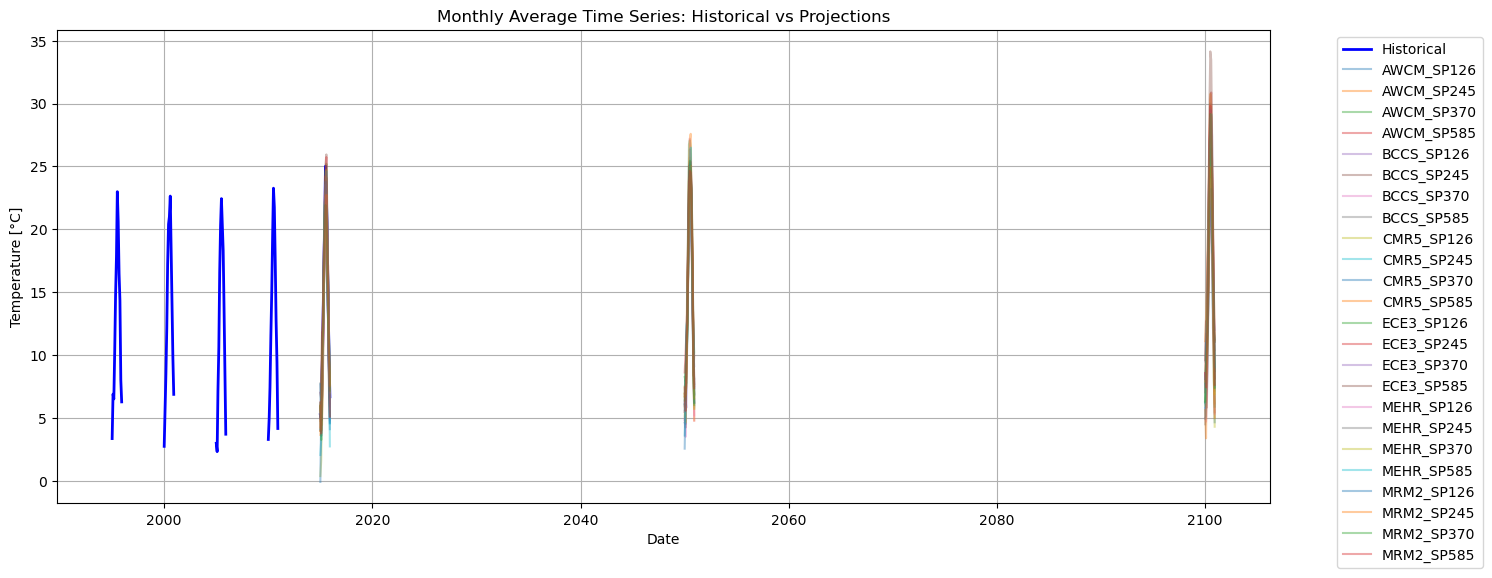

In [25]:
plt.figure(figsize=(15, 6))

# Plot historical line (blue)
plt.plot(hist_monthly.index, hist_monthly["H"], label="Historical", color="blue", linewidth=2)
# Plot all projections (gray lines with alpha for transparency)
for col in proj_monthly.columns:
    plt.plot(proj_monthly.index, proj_monthly[col], label=col, alpha=0.4)

# Highlight plot settings
plt.title("Monthly Average Time Series: Historical vs Projections")
plt.xlabel("Date")
plt.ylabel("Temperature [°C]")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", ncol=1)
plt.tight_layout()
plt.show()

The plot we get isn’t particularly informative, is it?

Let's zoom on a particular year

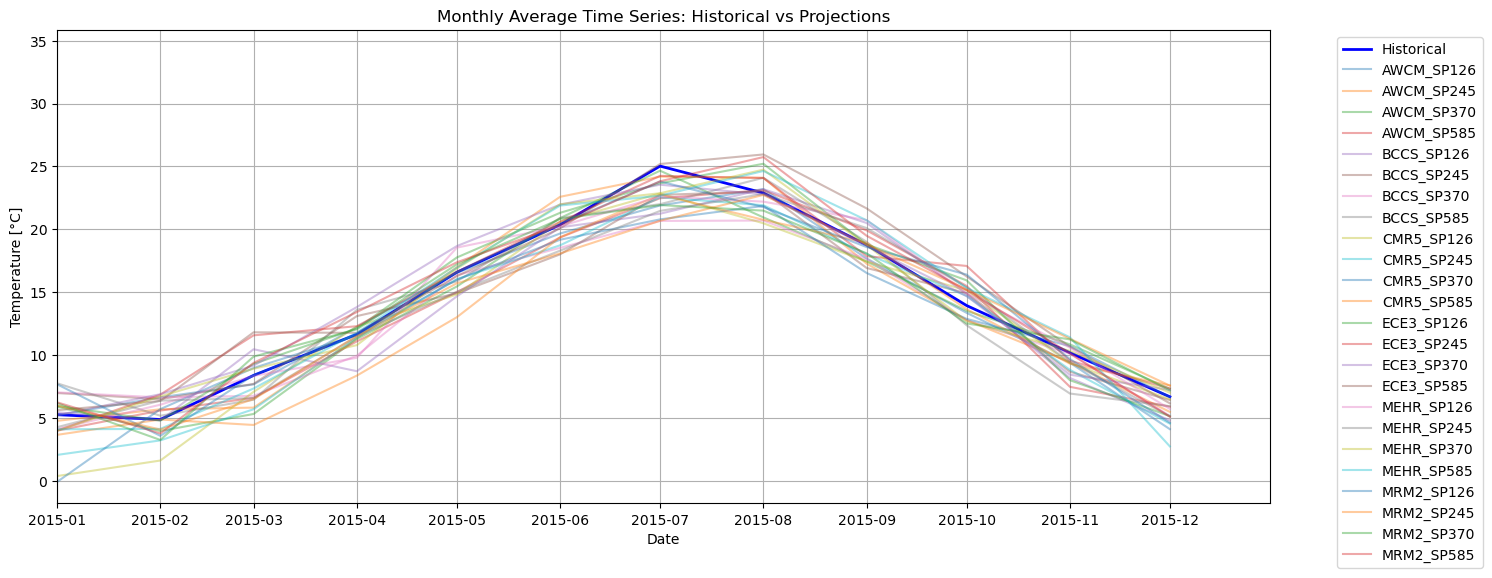

In [26]:
plt.figure(figsize=(15, 6))

# Plot historical line (blue)
plt.plot(hist_monthly.index, hist_monthly["H"], label="Historical", color="blue", linewidth=2)
# Plot all projections (gray lines with alpha for transparency)
for col in proj_monthly.columns:
    plt.plot(proj_monthly.index, proj_monthly[col], label=col, alpha=0.4)

# Highlight plot settings
plt.title("Monthly Average Time Series: Historical vs Projections")
plt.xlabel("Date")
plt.ylabel("Temperature [°C]")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", ncol=1)
plt.xlim(pd.to_datetime("2015-01-01"), pd.to_datetime("2015-12-31"))
plt.tight_layout()
plt.show()

We can better understand the ensemble of models and scenarios in comparison with the reanalysis. However, all these overlapping lines make the plot hard to interpret.
To simplify things, let’s create an envelope of the projections and use that for comparison with the historical time series.

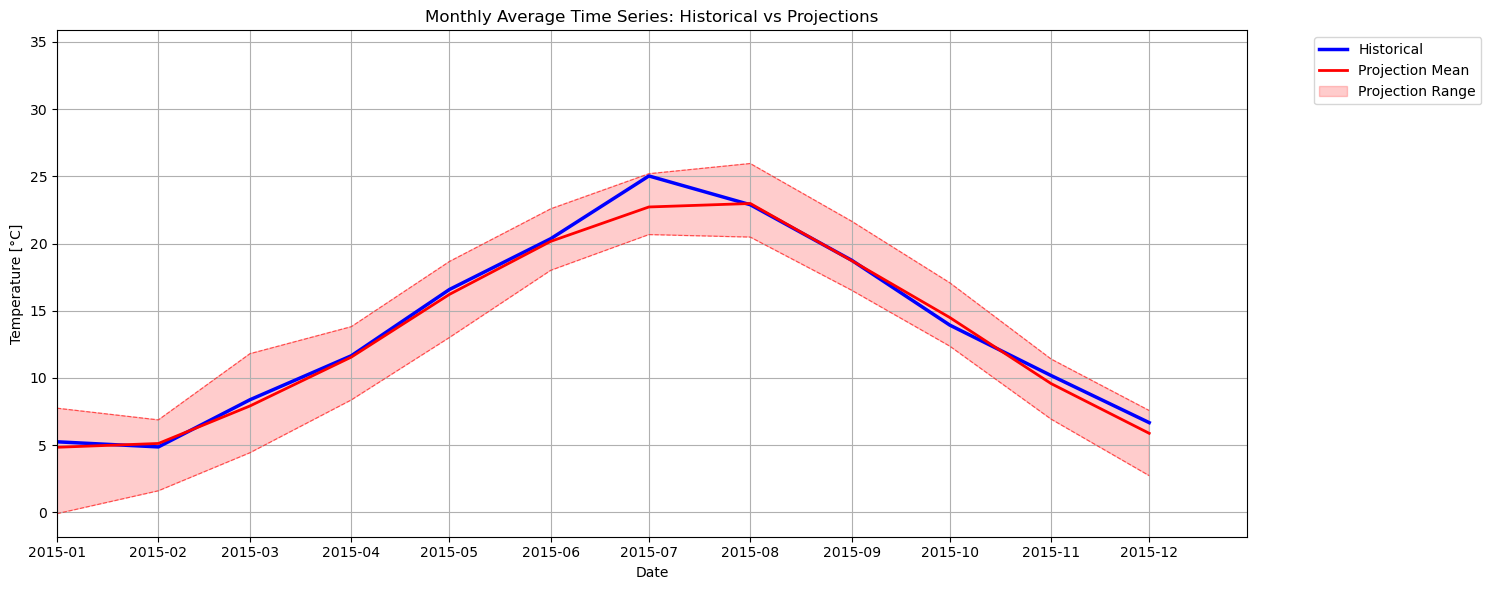

In [27]:
# Calculate the average, min, and max across all projection columns for 2015
proj_mean = proj_monthly.mean(axis=1)
proj_min = proj_monthly.min(axis=1)
proj_max = proj_monthly.max(axis=1)

# Plotting
plt.figure(figsize=(15, 6))

# 1. Plot historical data (thick blue line)
plt.plot(hist_monthly.index, hist_monthly["H"], label="Historical", color="blue", linewidth=2.5)

# 2. Plot mean of projections (thick red line)
plt.plot(proj_monthly.index, proj_mean, label="Projection Mean", color="red", linewidth=2)

# 3. Fill between min and max (shaded red envelope)
plt.fill_between(
    proj_monthly.index, proj_min, proj_max, color="red", alpha=0.2, label="Projection Range"
)

# 4. Outline the min and max envelope (thin red dashed lines)
plt.plot(proj_monthly.index, proj_min, color="red", linewidth=0.8, linestyle="--", alpha=0.6)
plt.plot(proj_monthly.index, proj_max, color="red", linewidth=0.8, linestyle="--", alpha=0.6)

# Final formatting
plt.title("Monthly Average Time Series: Historical vs Projections")
plt.xlabel("Date")
plt.ylabel("Temperature [°C]")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xlim(pd.to_datetime("2015-01-01"), pd.to_datetime("2015-12-31"))
plt.tight_layout()
plt.show()

Let's do the same but focusing on a particular SSP. We need to construct a new version of our dataframe (proj_subset) by selecting only a subset (selected_cols) of our columns, based on a defined selection criterion.

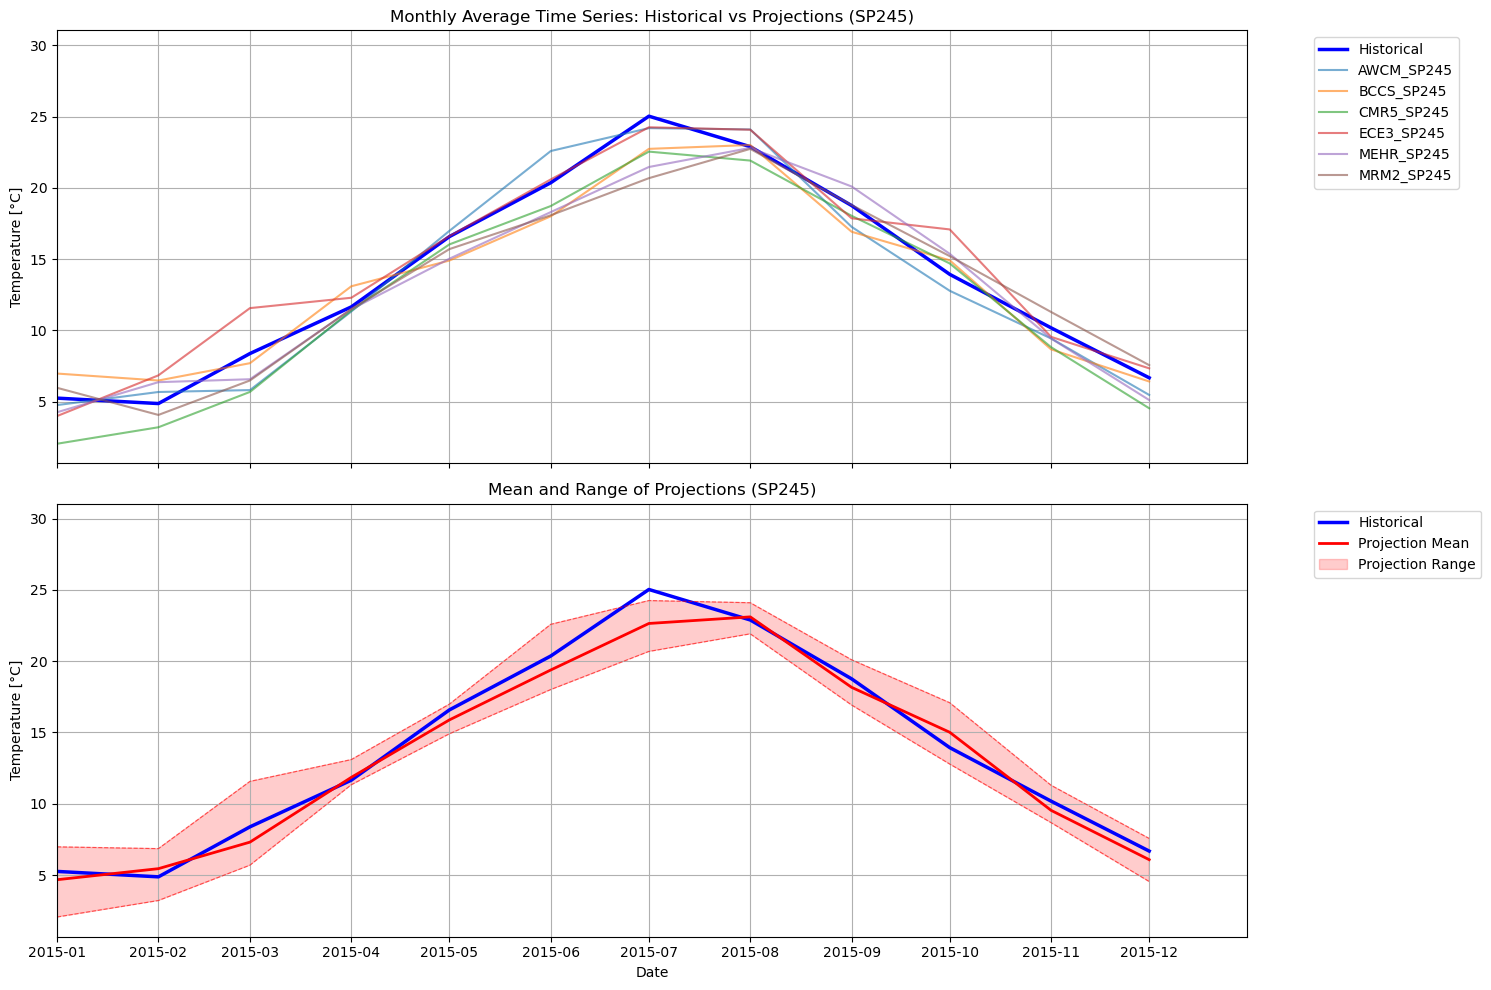

In [28]:
# --- Filter projection columns ending in specific scenario (e.g., 'SP245')
sp_suffix = "SP245"
selected_cols = [col for col in proj_monthly.columns if col.endswith(sp_suffix)]

# --- Calculate mean, min, max for the selected columns
proj_subset = proj_monthly[selected_cols]
proj_mean = proj_subset.mean(axis=1)
proj_min = proj_subset.min(axis=1)
proj_max = proj_subset.max(axis=1)

# --- Create subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(15, 10), sharex=True)

# --- Top subplot: Individual projections
ax1.plot(hist_monthly.index, hist_monthly["H"], label="Historical", color="blue", linewidth=2.5)
for col in selected_cols:
    ax1.plot(proj_monthly.index, proj_monthly[col], label=col, alpha=0.6)
ax1.set_title(f"Monthly Average Time Series: Historical vs Projections ({sp_suffix})")
ax1.set_ylabel("Temperature [°C]")
ax1.grid(True)
ax1.legend(bbox_to_anchor=(1.05, 1), loc="upper left", ncol=1)

# --- Bottom subplot: Mean + Envelope
ax2.plot(hist_monthly.index, hist_monthly["H"], label="Historical", color="blue", linewidth=2.5)
ax2.plot(proj_subset.index, proj_mean, label="Projection Mean", color="red", linewidth=2)
ax2.fill_between(
    proj_subset.index, proj_min, proj_max, color="red", alpha=0.2, label="Projection Range"
)
ax2.plot(proj_subset.index, proj_min, color="red", linestyle="--", linewidth=0.8, alpha=0.6)
ax2.plot(proj_subset.index, proj_max, color="red", linestyle="--", linewidth=0.8, alpha=0.6)

ax2.set_title(f"Mean and Range of Projections ({sp_suffix})")
ax2.set_xlabel("Date")
ax2.set_ylabel("Temperature [°C]")
ax2.grid(True)
ax2.legend(bbox_to_anchor=(1.05, 1), loc="upper left", ncol=1)

# --- Shared settings
plt.xlim(pd.to_datetime("2015-01-01"), pd.to_datetime("2015-12-31"))
plt.tight_layout()
plt.show()

Let's do the same but selecting a particular model.

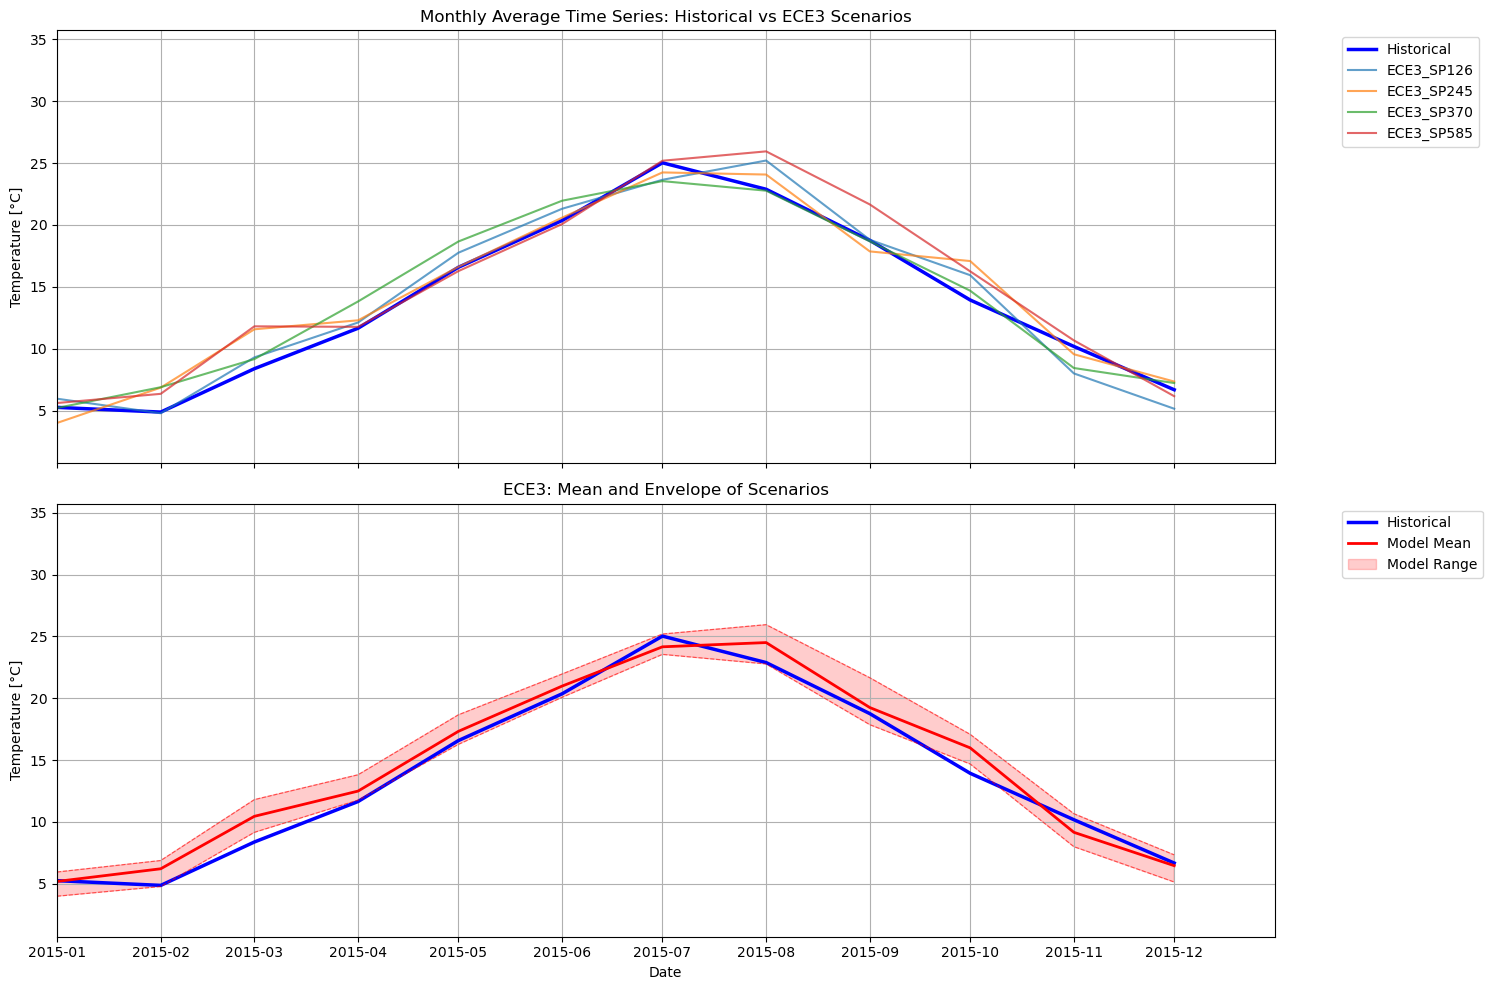

In [29]:
# --- Filter projection columns for a specific model
model_prefix = "ECE3"
selected_cols = [col for col in proj_monthly.columns if col.startswith(model_prefix)]

# --- Subset and compute statistics
proj_subset = proj_monthly[selected_cols]
proj_mean = proj_subset.mean(axis=1)
proj_min = proj_subset.min(axis=1)
proj_max = proj_subset.max(axis=1)

# --- Create subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(15, 10), sharex=True)

# --- Top subplot: individual scenario lines
ax1.plot(hist_monthly.index, hist_monthly["H"], label="Historical", color="blue", linewidth=2.5)
for col in selected_cols:
    ax1.plot(proj_monthly.index, proj_monthly[col], label=col, alpha=0.7)

ax1.set_title(f"Monthly Average Time Series: Historical vs {model_prefix} Scenarios")
ax1.set_ylabel("Temperature [°C]")
ax1.grid(True)
ax1.legend(bbox_to_anchor=(1.05, 1), loc="upper left", ncol=1)

# --- Bottom subplot: mean + min/max envelope
ax2.plot(hist_monthly.index, hist_monthly["H"], label="Historical", color="blue", linewidth=2.5)
ax2.plot(proj_subset.index, proj_mean, label="Model Mean", color="red", linewidth=2)
ax2.fill_between(proj_subset.index, proj_min, proj_max, color="red", alpha=0.2, label="Model Range")
ax2.plot(proj_subset.index, proj_min, color="red", linestyle="--", linewidth=0.8, alpha=0.6)
ax2.plot(proj_subset.index, proj_max, color="red", linestyle="--", linewidth=0.8, alpha=0.6)

ax2.set_title(f"{model_prefix}: Mean and Envelope of Scenarios")
ax2.set_xlabel("Date")
ax2.set_ylabel("Temperature [°C]")
ax2.grid(True)
ax2.legend(bbox_to_anchor=(1.05, 1), loc="upper left", ncol=1)

# --- Shared settings
plt.xlim(
    pd.to_datetime("2015-01-01"), pd.to_datetime("2015-12-31")
)  # Adjust or remove for full range
plt.tight_layout()
plt.show()

Let's look at the year 2100.

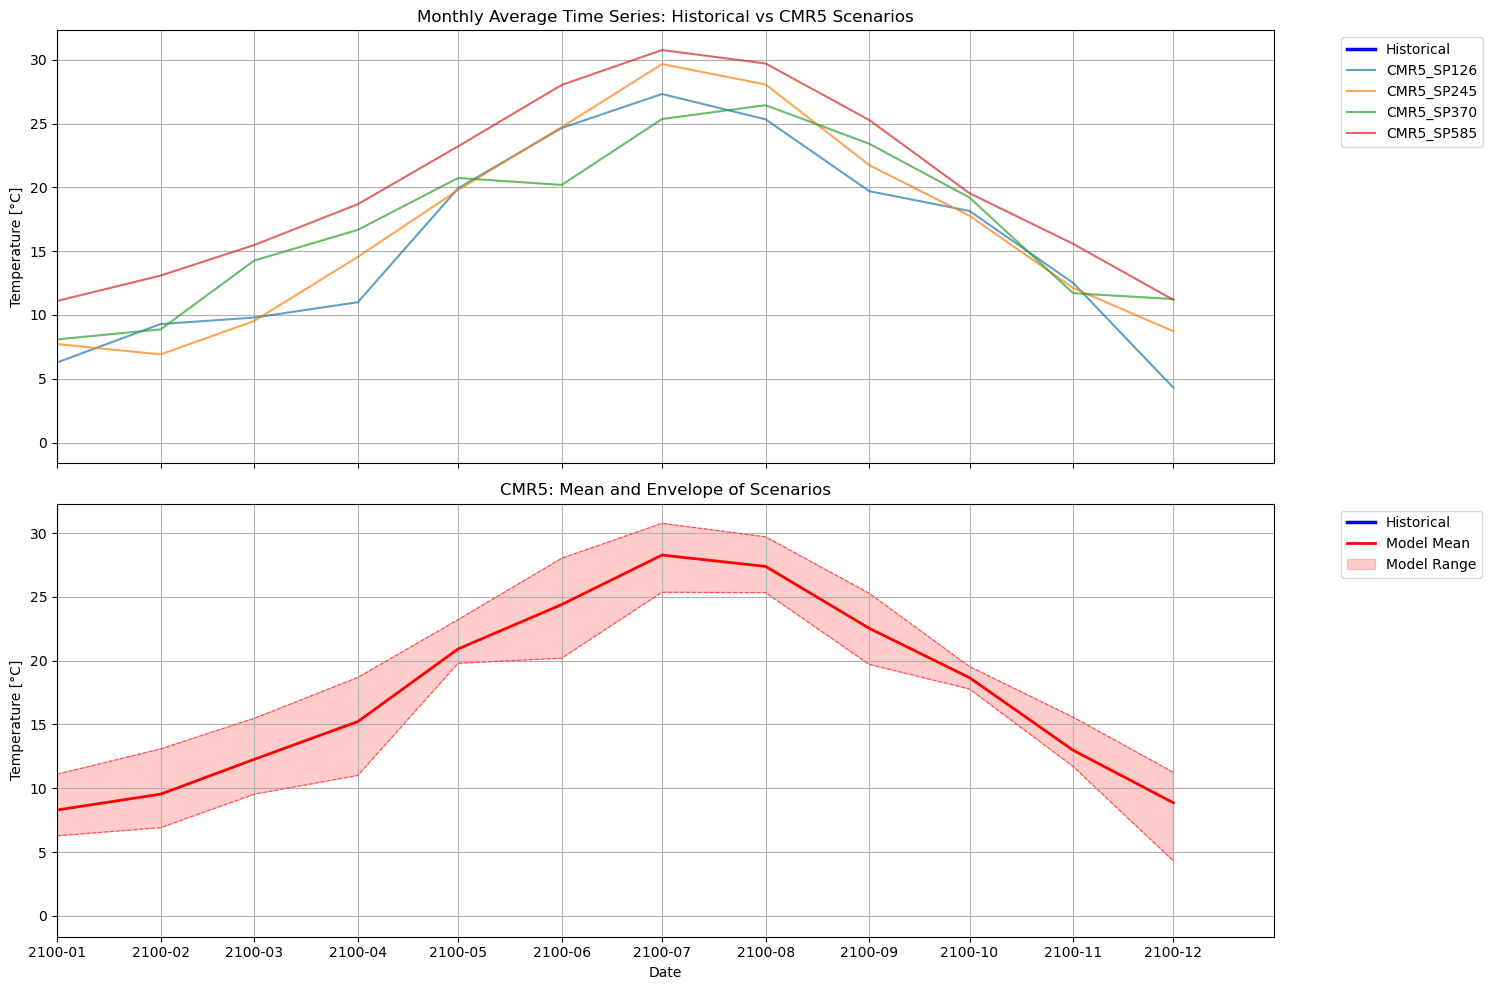

In [30]:
# --- Filter projection columns for a specific model
model_prefix = "CMR5"
selected_cols = [col for col in proj_monthly.columns if col.startswith(model_prefix)]

# --- Subset and compute statistics
proj_subset = proj_monthly[selected_cols]
proj_mean = proj_subset.mean(axis=1)
proj_min = proj_subset.min(axis=1)
proj_max = proj_subset.max(axis=1)

# --- Create subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(15, 10), sharex=True)

# --- Top subplot: individual scenario lines
ax1.plot(hist_monthly.index, hist_monthly["H"], label="Historical", color="blue", linewidth=2.5)
for col in selected_cols:
    ax1.plot(proj_monthly.index, proj_monthly[col], label=col, alpha=0.7)

ax1.set_title(f"Monthly Average Time Series: Historical vs {model_prefix} Scenarios")
ax1.set_ylabel("Temperature [°C]")
ax1.grid(True)
ax1.legend(bbox_to_anchor=(1.05, 1), loc="upper left", ncol=1)

# --- Bottom subplot: mean + min/max envelope
ax2.plot(hist_monthly.index, hist_monthly["H"], label="Historical", color="blue", linewidth=2.5)
ax2.plot(proj_subset.index, proj_mean, label="Model Mean", color="red", linewidth=2)
ax2.fill_between(proj_subset.index, proj_min, proj_max, color="red", alpha=0.2, label="Model Range")
ax2.plot(proj_subset.index, proj_min, color="red", linestyle="--", linewidth=0.8, alpha=0.6)
ax2.plot(proj_subset.index, proj_max, color="red", linestyle="--", linewidth=0.8, alpha=0.6)

ax2.set_title(f"{model_prefix}: Mean and Envelope of Scenarios")
ax2.set_xlabel("Date")
ax2.set_ylabel("Temperature [°C]")
ax2.grid(True)
ax2.legend(bbox_to_anchor=(1.05, 1), loc="upper left", ncol=1)

# --- Shared settings
plt.xlim(
    pd.to_datetime("2100-01-01"), pd.to_datetime("2100-12-31")
)  # Adjust or remove for full range
plt.tight_layout()
plt.show()

## Future vs. Current Temperature

Let's go back to the ugly plot

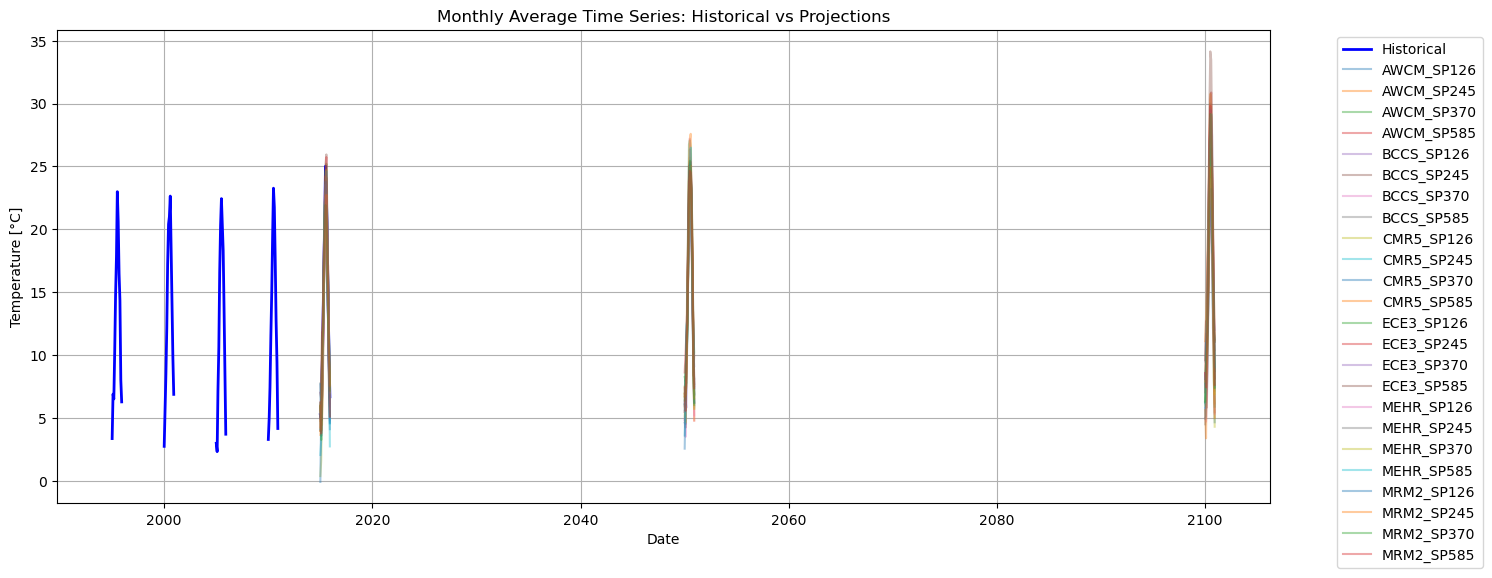

In [31]:
plt.figure(figsize=(15, 6))

# Plot historical line (blue)
plt.plot(hist_monthly.index, hist_monthly["H"], label="Historical", color="blue", linewidth=2)
# Plot all projections (gray lines with alpha for transparency)
for col in proj_monthly.columns:
    plt.plot(proj_monthly.index, proj_monthly[col], label=col, alpha=0.4)

# Highlight plot settings
plt.title("Monthly Average Time Series: Historical vs Projections")
plt.xlabel("Date")
plt.ylabel("Temperature [°C]")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", ncol=1)
plt.tight_layout()
plt.show()

Let's consider the yearly averages this time

In [32]:
# Resample yearly and average
hist_yearly = new_hist_df.resample("YS").mean()
proj_yearly = new_proj_df.resample("YS").mean()

Let's plot the yearly averages of historical and projections

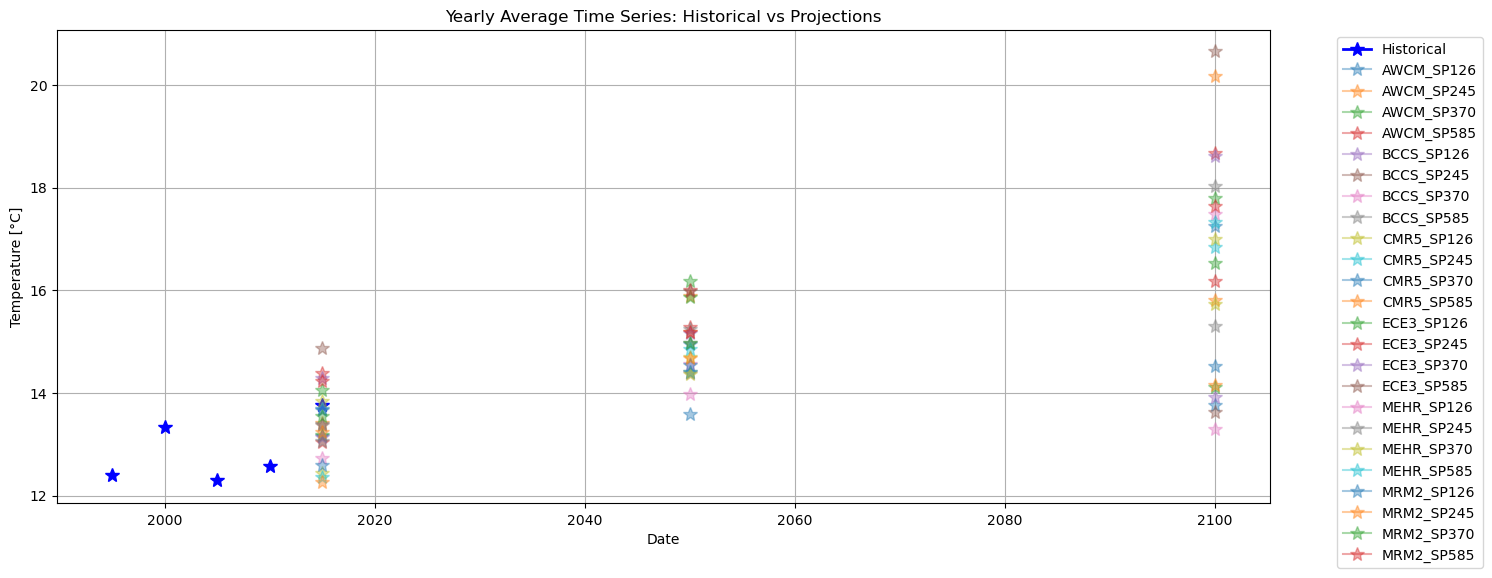

In [33]:
plt.figure(figsize=(15, 6))

# Plot historical line (blue)
plt.plot(
    hist_yearly.index,
    hist_yearly["H"],
    label="Historical",
    color="blue",
    linewidth=2,
    marker="*",
    ms=10,
)
# Plot all projections (gray lines with alpha for transparency)
for col in proj_yearly.columns:
    plt.plot(proj_yearly.index, proj_yearly[col], label=col, alpha=0.4, marker="*", ms=10)

# Highlight plot settings
plt.title("Yearly Average Time Series: Historical vs Projections")
plt.xlabel("Date")
plt.ylabel("Temperature [°C]")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", ncol=1)
plt.tight_layout()
plt.show()

Too many stars, let's start by calculating the mean and rmse of historical data (obtaining a sort of climatology)

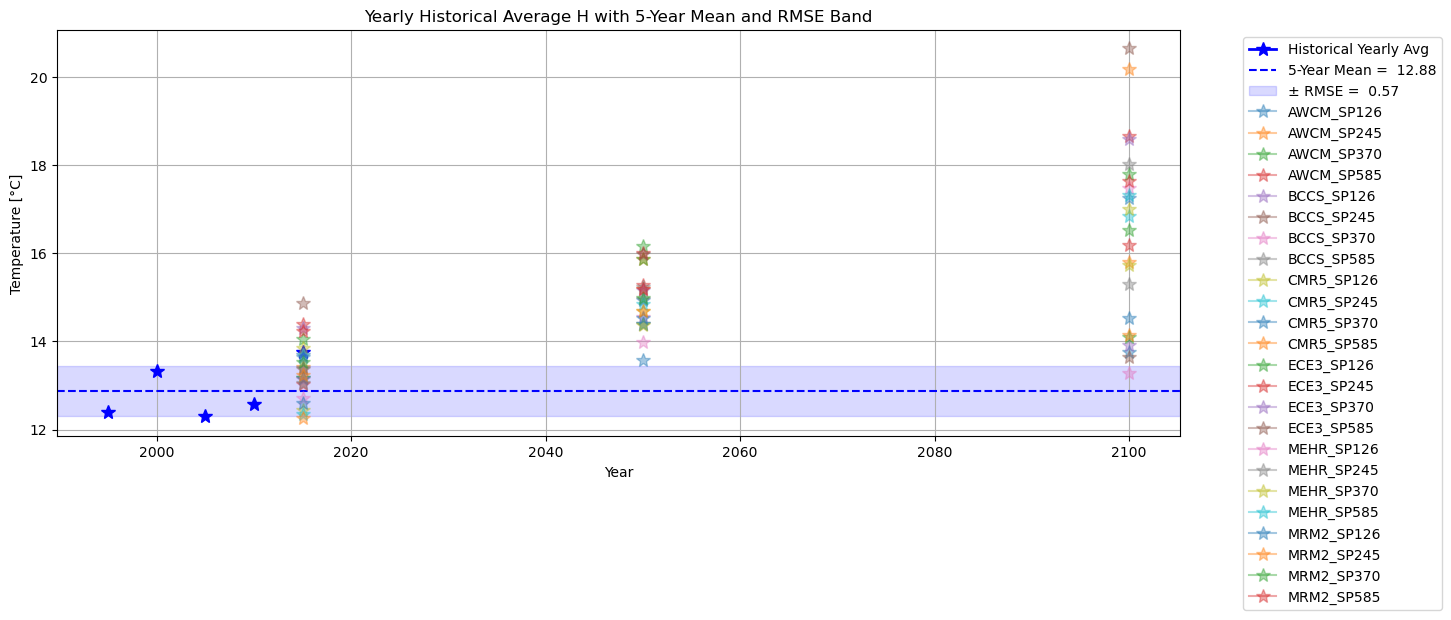

In [34]:
# Step 1: Calculate the average of the 5 historical yearly values
hist_avg = hist_yearly["H"].mean()
hist_rmse = np.sqrt(np.mean((hist_yearly["H"] - hist_avg) ** 2))

# Step 2: Plot historical yearly data
plt.figure(figsize=(12, 5))
plt.plot(
    hist_yearly.index,
    hist_yearly["H"],
    label="Historical Yearly Avg",
    color="blue",
    linewidth=2,
    marker="*",
    ms=10,
)

# Step 3: Plot horizontal line for the 5-year average
plt.axhline(
    y=hist_avg, color="blue", linestyle="--", linewidth=1.5, label=f"5-Year Mean = {hist_avg: .2f}"
)

# Step 4: Add blue band for RMSE range (mean ± RMSE)
plt.axhspan(
    hist_avg - hist_rmse,
    hist_avg + hist_rmse,
    color="blue",
    alpha=0.15,
    label=f"± RMSE = {hist_rmse: .2f}",
)

# Step 5: Plot all projections
for col in proj_yearly.columns:
    plt.plot(proj_yearly.index, proj_yearly[col], label=col, alpha=0.4, marker="*", ms=10)

# Final plot settings
plt.title("Yearly Historical Average H with 5-Year Mean and RMSE Band")
plt.xlabel("Year")
plt.ylabel("Temperature [°C]")
plt.grid(True)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

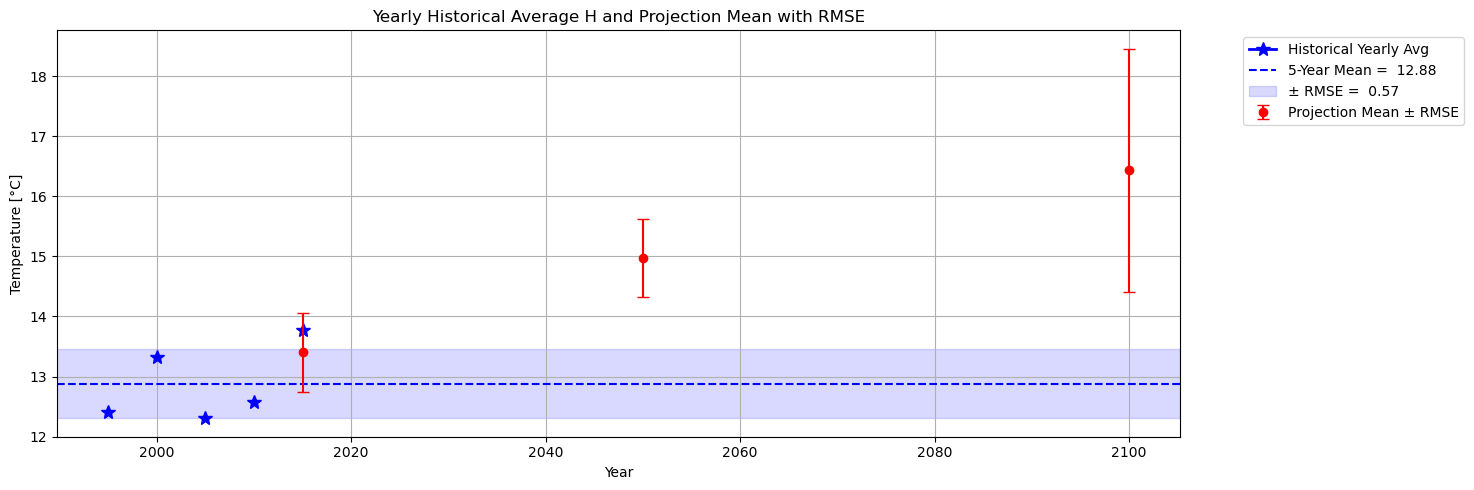

In [35]:
# Step 1: Historical average and RMSE
hist_avg = hist_yearly["H"].mean()
hist_rmse = np.sqrt(np.mean((hist_yearly["H"] - hist_avg) ** 2))

# Step 2: Compute projection mean and RMSE per year
proj_mean = proj_yearly.mean(axis=1)
proj_rmse = np.sqrt(((proj_yearly.sub(proj_mean, axis=0)) ** 2).mean(axis=1))

# Step 3: Plot
plt.figure(figsize=(12, 5))

# Historical values
plt.plot(
    hist_yearly.index,
    hist_yearly["H"],
    label="Historical Yearly Avg",
    color="blue",
    linewidth=2,
    marker="*",
    ms=10,
)

# Horizontal mean line and RMSE band for historical
plt.axhline(
    y=hist_avg, color="blue", linestyle="--", linewidth=1.5, label=f"5-Year Mean = {hist_avg: .2f}"
)
plt.axhspan(
    hist_avg - hist_rmse,
    hist_avg + hist_rmse,
    color="blue",
    alpha=0.15,
    label=f"± RMSE = {hist_rmse: .2f}",
)

# Projection mean with RMSE error bars
plt.errorbar(
    proj_yearly.index,
    proj_mean,
    yerr=proj_rmse,
    fmt="o",  # Circle marker
    color="red",
    ecolor="red",
    elinewidth=1.5,
    capsize=4,
    label="Projection Mean ± RMSE",
)

# Final plot formatting
plt.title("Yearly Historical Average H and Projection Mean with RMSE")
plt.xlabel("Year")
plt.ylabel("Temperature [°C]")
plt.grid(True)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

In [36]:
# Step 1: Compute historical 5-year mean
hist_avg = hist_yearly["H"].mean()

# Step 2: Compute yearly projection mean
proj_mean = proj_yearly.mean(axis=1)

# Step 3: Compute increase over historical average
increase_vs_hist = proj_mean - hist_avg

# Step 4: Build the DataFrame
summary_table = pd.DataFrame(
    {
        "Year": proj_mean.index.year,
        "Projection Mean [°C]": proj_mean.values,
        "Increase vs Historical Mean [°C]": increase_vs_hist.values,
    }
)

# Drop rows with any NaN values
summary_table.dropna(inplace=True)

# Optional: round for neat display
summary_table = summary_table.round(3)

# Display the table
print(summary_table.to_string(index=False))

 Year  Projection Mean [°C]  Increase vs Historical Mean [°C]
 2015                13.401                             0.523
 2050                14.972                             2.094
 2100                16.435                             3.557


## Take home messages 📌

*   Climate data stored in CSV files can be easily read, explored, and summarized using pandas.
*   Mean values over time can be computed and compared across countries using simple operations.
*   Time series for selected countries can be plotted using matplotlib for visual comparison.
*   Resampling to lower temporal resolution can be useful to better visualize and compare the data.
*   A calculation of climate change trends can be done pretty easily.